In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse import csr_matrix
import sklearn
from sklearn.decomposition import TruncatedSVD
import numpy as np
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
import math

### Read the dataset : Amazon Clothes

In [2]:
import pandas as pd
import gzip
from PIL import Image
from PIL import ImageOps
import urllib.request as urllib
import urllib.error as err

import io
import numpy as np

def parse(path):
    g = gzip.open(path, 'rb')
    for line in g:
        yield eval(line)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

In [3]:
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"
5,A27UF1MSF3DB2,0000031887,"C-Lo ""Cynthia""","[0, 0]",I received this today and I'm not a fan of it ...,4.0,It's ok,1396224000,"03 31, 2014"
6,A16GFPNVF4Y816,0000031887,design maven,"[0, 0]",Bought this as a backup to the regular ballet ...,5.0,Great for dress-up and for ballet practice,1399075200,"05 3, 2014"
7,A2M2APVYIB2U6K,0000031887,Jamie P.,"[0, 0]",Great tutu for a great price. It isn't a &#34;...,5.0,Great value,1356220800,"12 23, 2012"
8,A1NJ71X3YPQNQ9,0000031887,JBerger,"[0, 0]","My daughter liked this, and it with her costum...",4.0,Good,1384041600,"11 10, 2013"
9,A3EERSWHAI6SO,0000031887,"Jeffrey Hollingshead ""Jillian hollingshead""","[7, 8]",For what I paid for two tutus is unbeatable an...,5.0,WOW !! ..is all I have to say!,1349568000,"10 7, 2012"


In [4]:
amazon_clothes = df[['reviewerID','asin','overall','reviewTime','unixReviewTime']]

In [5]:
amazon_clothes.columns = ["User_Id", "Item_Id", "Rating", "TimeStamp","TimeStamp2"]

### Frequency plot for different types of ratings

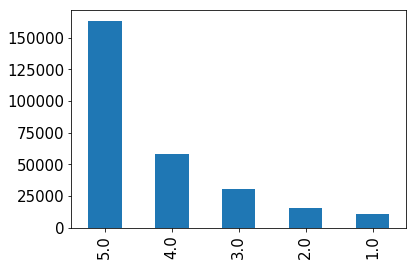

In [6]:
plt.rc("font",size=15)#Plot count for each rating
amazon_clothes.Rating.value_counts(sort=True).plot(kind='bar')
plt.show()

In [7]:
#Get list of most frequently rated items
average_rating = pd.DataFrame(amazon_clothes.groupby('Item_Id')['Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(amazon_clothes.groupby('Item_Id')['Rating'].count())
average_rating = average_rating.sort_values('ratingCount', ascending=False)
average_rating = average_rating.reset_index()
frequent_rated_items = average_rating[:90]

In [8]:
#Subset the data to include only most frequently rated items
amazon_clothes_item_subset = amazon_clothes[(amazon_clothes['Item_Id'].isin(frequent_rated_items.Item_Id)).tolist()]

In [9]:
#Get list of users that most frequently rate items
user_rated_most = pd.DataFrame(amazon_clothes_item_subset.groupby('User_Id')['Item_Id'].count())
user_rated_most = user_rated_most.sort_values('Item_Id', ascending=False)
user_rated_most = user_rated_most.reset_index()
user_rated_most.columns = ["User_Id", "rated_items"]
top_user_rated_most = user_rated_most[:1000]

In [10]:
#Subset the data to include only users that most frequently rate items
amazon_clothes_user_subset = amazon_clothes_item_subset[(amazon_clothes_item_subset['User_Id'].isin(top_user_rated_most.User_Id)).tolist()]    

### Test Dataset Sampling

In [11]:
#Do random sampling of subset of data to create a test set
import random
# Parameter: dataset is the train set from which we take test dataset
# Parameter: k is the number of users-item combination for which we want to predict ratings
def create_testdataset(dataset,k):
    test_df = pd.DataFrame(columns=["User_Id","Item_Id","Rating"])
    for i in range(0,k):
        index = random.choice(dataset.index.values.tolist())
        user = dataset.loc[index,'User_Id']
        item = dataset.loc[index,'Item_Id']
        rating = dataset.loc[index,'Rating']
        df = pd.DataFrame([[user,item,rating]],columns=["User_Id","Item_Id","Rating"])
        test_df = test_df.append(df)
    return test_df


In [12]:
# %store -r test_rows
test_df = create_testdataset(amazon_clothes_user_subset,10)
test_df = test_df.reset_index()

In [13]:
#Print no. of unique users and items in train set
print(amazon_clothes_user_subset.Item_Id.unique().shape[0])
print(amazon_clothes_user_subset.User_Id.unique().shape[0])

90
1000


### Check sparsity of user_item matrix

In [14]:
#Create user-item matrix from train set dataframe
user_item_pivot = amazon_clothes_user_subset.pivot(index="User_Id",columns="Item_Id", values="Rating")
userId = user_item_pivot.index
itemId = user_item_pivot.columns
user_item_matrix = csr_matrix(user_item_pivot.values)
user_item_pivot_filled_zeros = user_item_pivot.fillna(0)
user_item_matrix_filled_zeros = csr_matrix(user_item_pivot_filled_zeros.values)

In [15]:
#Remove the ratings of rows in test set from train set
for i in range(0,test_df.shape[0]):
    user_item_pivot.loc[test_df.User_Id[i]][test_df.Item_Id[i]] = np.nan

In [16]:
#Calculate sparsity of user_item matrix
missing = pd.DataFrame(np.isnan(user_item_pivot).sum()/np.prod(user_item_pivot.shape))
missing = missing.reset_index()
missing.columns = ["Item_Id", "percent_missing"]
missing.percent_missing.sum()

0.9702777777777777

### Use Birch Clustering to create peer group for each user

In [17]:
#Cross validation and hyper-parameter tuning to find optimal number of clusters and branching factor
from sklearn.cluster import Birch
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import metrics
RAND_STATE=50  # for reproducibility and consistency
folds=3
k_fold = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE)
hyperparams = {
    "branching_factor": [20,50,70,100],
    "n_clusters": [5,10,50,70,100,200],
}

bir = Birch()  # sets jobs equal to number of cores

def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(X, clusters)
    return score

ensemble = GridSearchCV(
    estimator=bir,
    param_grid=hyperparams,
    scoring=silhouette_score,
    cv=k_fold
)
ensemble.fit(user_item_matrix_filled_zeros)
print(ensemble.best_params_)

{'branching_factor': 50, 'n_clusters': 100}


In [18]:
print(ensemble.best_params_['branching_factor'])
print(ensemble.best_params_['n_clusters'])

50
100


In [19]:
#initialise and fit birch clustering model to dataset
import numpy as np
from sklearn.cluster import Birch
estimator = Birch(branching_factor= ensemble.best_params_['branching_factor'],n_clusters=ensemble.best_params_['n_clusters'])
estimator.fit(user_item_matrix_filled_zeros)
estimator.labels_
neighbors = {i: np.where(estimator.labels_ == i)[0] for i in range(estimator.n_clusters)}

In [20]:
#returns k nearest neighbors given a user id
def get_neighbors2(query_index,user_item_matrix_filled_zeros):
    for cluster in neighbors:
        cluster = neighbors[cluster].tolist()
        print()
        if query_index in cluster:
            return [user_item_matrix_filled_zeros.index[x] for x in cluster if x != query_index]

### Normalize user-item Matrix: Subtracting the Mean

In [21]:
#calculate mean of ratings for each user
user_item_pivot['Mean'] = user_item_pivot.mean(axis=1)
user_item_pivot.head()

Item_Id,B000072UMJ,B0000ANHST,B0000C321X,B00012O12A,B0001ZNZJM,B0002TOZ1E,B0006LMBJ6,B0007CKMA4,B0007QCOTM,B0007YR8WW,...,B00BNB3A0W,B00CIBCJ62,B00CKGB85I,B00CN47GXA,B00D1MR8YU,B00DMWQK0W,B00DMWQOYY,B00DNQIIE8,B00DQYNS3I,Mean
User_Id,,,,,,,,,,,,,,,,,,,,,
A103979529MRJY0U56QI4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,4.666667
A106GRKSYBW4X4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.666667
A107SEAOVM1W10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.333333
A10H6RT7OL6LRW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.333333
A10ZWCAQW773O2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.333333


In [22]:
#store in another matrix and subract mean column from all other columns in user-item matrix
user_item_pivot2=user_item_pivot
user_item_pivot2 = user_item_pivot2.sub(user_item_pivot['Mean'].reset_index().Mean.tolist(),axis=0)

In [23]:
user_item_pivot2['Mean'] = user_item_pivot['Mean']
user_item_pivot2.head()

Item_Id,B000072UMJ,B0000ANHST,B0000C321X,B00012O12A,B0001ZNZJM,B0002TOZ1E,B0006LMBJ6,B0007CKMA4,B0007QCOTM,B0007YR8WW,...,B00BNB3A0W,B00CIBCJ62,B00CKGB85I,B00CN47GXA,B00D1MR8YU,B00DMWQK0W,B00DMWQOYY,B00DNQIIE8,B00DQYNS3I,Mean
User_Id,,,,,,,,,,,,,,,,,,,,,
A103979529MRJY0U56QI4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.666667,NaN,NaN,NaN,NaN,NaN,0.333333,0.333333,NaN,4.666667
A106GRKSYBW4X4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,4.666667
A107SEAOVM1W10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.333333
A10H6RT7OL6LRW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.333333
A10ZWCAQW773O2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.333333


### Calulate similarity matrix using Pearson Similarity

In [24]:
#create user-user similarity matrix
user_item_normalized = user_item_pivot2.fillna(0).iloc[:,:-1]
pearson_similarity = user_item_normalized.dot(user_item_normalized.T)
sim_denom_sqrt = np.sqrt(np.sum(np.square(user_item_normalized), axis=1))
sim_denom_sqrt = np.array(sim_denom_sqrt)[np.newaxis]
similarity_denom = sim_denom_sqrt.T.dot(sim_denom_sqrt)
pearson_similarity = (pearson_similarity/similarity_denom).fillna(0)

### Fill the predicted user-item matrix : Neighborhood-based

In [25]:
#create user_item predicted values matrix
user_item_df = pd.DataFrame(columns=["User_Id","Item_Id","Rating"])
user_item_df['User_Id'] = amazon_clothes_user_subset['User_Id']
user_item_df['Item_Id'] = amazon_clothes_user_subset['Item_Id']
user_item_df['Rating'] = [0]*amazon_clothes_user_subset.shape[0]
user_item_predicted = user_item_df.pivot(index="User_Id",columns="Item_Id", values="Rating")

In [26]:
#predict ratings that are missing in user-item matrix using ratings of users in peer set and similarity matrix
for i in range(0,user_item_pivot2.shape[0]):
    print(i)
    target_user = user_item_pivot2.index[i]
    items_target = user_item_pivot2.loc[target_user]
    mean_target_user=items_target['Mean']
    items_target = items_target.reset_index()
    items_target_negative = items_target[items_target[target_user].isna()]
    nearest_neighbor = get_neighbors2(i,user_item_pivot2)
  

    
    for j in items_target_negative['Item_Id']:
        sum_rating_nn = 0
        similarity_nn = 0
        for k in nearest_neighbor:
            if not (math.isnan(user_item_pivot2.loc[k][j])):
                sum_rating_nn=sum_rating_nn+((pearson_similarity.loc[target_user][k])*(user_item_pivot2.loc[k][j]))
                similarity_nn = similarity_nn + abs(pearson_similarity.loc[target_user][k])
                
        if(similarity_nn!=0):
            user_item_predicted.loc[target_user][j] = mean_target_user + (sum_rating_nn/similarity_nn)
        else:
            user_item_predicted.loc[target_user][j] = mean_target_user
            

0
















1









2

































3



















































































4


























































































5






6


























7

































8


































































9


































































10


















































































11




































































































12
















13




























































14

































































































15






16




















17




















































































18










































19

















195



















196





























































































197


















































198




















199


























































































200







































































201








202






































203







204



































































































205












































































206





























207

































































208

































































209






















































































210

































































































211




























346




































347
















348




































349























































350
















































351














































352









































































353








































































354




































355





























356































































































357





































































358



























359




































































































360
























































































361


























































































362











521









































































522




























523













524




















525














526
































































527


















528













529















































































530
































531






































532























533















































534









535






























536


















































537




























































538












































































539
































































540































































541
































542




































































704








705



706































































707











708


















709

710















































711




































712













































713























































714





715

































































































716





















































717










































718































719



















720
















721






















722

































723
















































724








































































725














726











727


























































































728






























































885









































































886















































887


















888




























































889


















890


















































891

































































































892





















































893



























































































894











895



































































896



















897


































































898














































899







































































900




























901







































902















































903

























In [27]:
#prints predicted and orginal ratings given test set and array of predicted ratings for user-item combinations in test set
def print_ratings(test_df,user_item_predicted):
    user_item_predicted_array = []
    for i in range(0,test_df.shape[0]):
        print("User ID:", test_df.User_Id[i])
        print("Predicted Ratings:", user_item_predicted.loc[test_df.User_Id[i]][test_df.Item_Id[i]])
        print("Original Ratings:",test_df.Rating[i])
        print("\n")
        user_item_predicted_array.append(user_item_predicted.loc[test_df.User_Id[i]][test_df.Item_Id[i]])
    
    return np.array(user_item_predicted_array)
    

### Accuracy Metrics

#### Root Mean Square Error

In [28]:
#returns rmse given predicted and observed rating arrays
def calculate_rmse(predicted_rating,observed_rating):
    rmse = np.sqrt((np.sum(np.square(predicted_rating-observed_rating)))/(len(observed_rating)))
    return rmse

#### Mean Absolute Error

In [29]:
#returns mae given predicted and observed rating arrays
def calculate_mae(predicted_rating,observed_rating):
    mae = (np.sum(abs(predicted_rating-observed_rating)))/(len(observed_rating))
    return mae

#### Observed and Predicted Ratings

In [30]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A3JAITM5A93M0U
Predicted Ratings: 2.0
Original Ratings: 5.0


User ID: A1LHXIEVRGSV5U
Predicted Ratings: 3.0
Original Ratings: 4.0


User ID: A2T85HNZB93WL3
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: A1MCPWU2DCSRDZ
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: A3TVX5FAPEB7CW
Predicted Ratings: 4.0
Original Ratings: 5.0


User ID: A73WC1UJ052XA
Predicted Ratings: 3.0386898685566255
Original Ratings: 5.0


User ID: A13UGU4VH0JLR
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: A22SXBCTCPEFRP
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: A1UJ9PL8CQ5TEQ
Predicted Ratings: 1.0
Original Ratings: 4.0


User ID: A1MFXOLD6TN0PM
Predicted Ratings: 2.0
Original Ratings: 3.0


Root Mean Square Error for Test Data: 1.576284791264016
Mean Absolute Error for Test Data: 1.0961310131443374


#### Item Coverage

In [31]:
#returns item coverage for dataset ie. percentage of items predicted from all items.
def calculate_items_coverage(k,user_item_predicted):
    items_recommended =[]
    for i in range(0,user_item_predicted.shape[0]):
        top_k_items=[]
        target_user = user_item_predicted.index[i]
        top_k_items=top_k_items_recommended(k,target_user,user_item_predicted)
        items_recommended.extend(top_k_items)
        
    items_recommended = np.unique(np.array(items_recommended)).tolist()
    print((items_recommended))
    items_coverage = len(items_recommended)/user_item_predicted.shape[1]
    return items_coverage

In [32]:
#returns top-k recommened items for any user
def top_k_items_recommended(k,userid,user_item_predicted):
    items_target = user_item_predicted.loc[userid].reset_index()
    top_k_items = items_target.sort_values(userid, ascending=False)[:k].Item_Id.tolist()
    return top_k_items

#### Catalog Coverage

In [33]:
#returns catalog coverage for dataset ie. percentage of user-item pairs predicted from all possible user-item pairs
def calculate_catalog_coverage(k,user_item_predicted):
    total_user_item_pairs = user_item_predicted.shape[0]*user_item_predicted.shape[1]
    #since recommending items to all the users
    total_user_items_recommended = user_item_predicted.shape[0]*k
    coverage_ratio = total_user_items_recommended/total_user_item_pairs
    return coverage_ratio

In [34]:
calculate_catalog_coverage(5,user_item_predicted)

0.05555555555555555

In [35]:
calculate_items_coverage(5,user_item_predicted)

['B000072UMJ', 'B0000ANHST', 'B0000C321X', 'B00012O12A', 'B0001ZNZJM', 'B0006LMBJ6', 'B0007CKMA4', 'B0007YR8WW', 'B0007YVP1W', 'B0007YXTOS', 'B0008172S4', 'B0008EOEPK', 'B0009F0Z38', 'B000DZUGOM', 'B000EIJG0I', 'B000FH4JJQ', 'B000GOVRDE', 'B000J6ZYL0', 'B000KEG4V0', 'B000KKTPD8', 'B000O32MLI', 'B000PH25X8', 'B000QW6LE6', 'B000T9VK56', 'B000XDDERK', 'B0012QM8IS', 'B0013KDS96', 'B001AOZVSQ', 'B001IB70JY', 'B001Q5QLP6', 'B0026P45QW', 'B002APTA9K', 'B002KMI7OC', 'B002PHLVJA', 'B002RADHJC', 'B0031U0PO2', 'B003DNR2HK', 'B003DNR4XC', 'B003NX87U6', 'B003XDVUEQ', 'B004M6XUI2', 'B004Q7AB4I', 'B004R1II48', 'B004YM2FV2', 'B004Z1CZDK', 'B0051D7GF8', 'B0051U15E4', 'B0053XF2U2', 'B00550PLV8', 'B0058XIMMM', 'B005CSNTJY', 'B005GYGD7O', 'B005LERHD8', 'B005UVM368', 'B0067GUM2W', 'B0068VM5T4', 'B006PGGJOE', 'B006SCSOOS', 'B0074T7TY0', 'B0076R6KY0', 'B0078FXHNM', 'B007NLX16O', 'B007RD9DS8', 'B007WA3K4Y', 'B007WAEBPQ', 'B007WAU1VY', 'B007WNWEFC', 'B0081IZ3UA', 'B0083S18LQ', 'B008KK0ZJ8', 'B008NCYALM', 'B008

0.9333333333333333